In [65]:
from datasets import load_dataset
from datasets import DatasetDict

dataset = load_dataset("parquet", data_files='../data/rucphen_precipitation_clean.parquet')
dataset.sort('timestamp')
train_testvalid = dataset['train'].train_test_split(test_size=0.3, shuffle=False)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, shuffle=False)
# gather everyone if you want to have a single DatasetDict
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'validation': test_valid['train']})

dataset = dataset.rename_column('polygon_1663', 'precipitation')

In [66]:
dataset

DatasetDict({
    train: Dataset({
        features: ['timestamp', 'precipitation', 'percentage'],
        num_rows: 49537
    })
    test: Dataset({
        features: ['timestamp', 'precipitation', 'percentage'],
        num_rows: 10616
    })
    validation: Dataset({
        features: ['timestamp', 'precipitation', 'percentage'],
        num_rows: 10615
    })
})

In [67]:
validation_example = dataset["validation"]
train_example = dataset["train"]
test_example = dataset["test"]

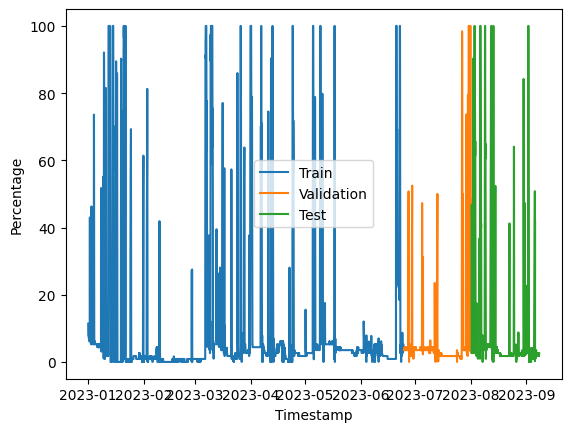

In [68]:
import matplotlib.pyplot as plt

# Extracting data
timestamp = validation_example['timestamp']
percentage = validation_example['percentage']

# Plotting
figure, axes = plt.subplots()

# Plotting precipitation
axes.plot(train_example['timestamp'],train_example['percentage'], label='Train')
axes.plot(validation_example['timestamp'],validation_example['percentage'], label='Validation')
axes.plot(test_example['timestamp'],test_example['percentage'], label='Test')
axes.legend()
# Labeling axes
axes.set_xlabel('Timestamp')
axes.set_ylabel('Percentage')

plt.show()

In [ ]:
from functools import lru_cache

import pandas as pd
import numpy as np


@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_timestamp_field(batch, freq):
    batch["timestamp"] = [convert_to_pandas_period(date, freq) for date in batch["timestamp"]]
    return batch

In [ ]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [ ]:
freq = "5min"
prediction_length = 

In [2]:
from functools import partial

train_dataset.set_transform(partial(transform_timestamp_field, freq="5min"))
test_dataset.set_transform(partial(transform_timestamp_field, freq="5min"))

NameError: name 'train_dataset' is not defined

Get the lags for 5 minutes frequency: 1153 ~= 3 hours before

In [3]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency("5min")
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 22, 23, 24, 25, 26, 34, 35, 36, 37, 38, 287, 288, 289, 575, 576, 577, 863, 864, 865, 1151, 1152, 1153]


## Define the model

Next, let's instantiate a model. The model will be trained from scratch, hence we won't use the `from_pretrained` method here, but rather randomly initialize the model from a [`config`](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerConfig).

We specify a couple of additional parameters to the model:
- `prediction_length` (in our case, `24` months): this is the horizon that the decoder of the Transformer will learn to predict for;
- `context_length`: the model will set the `context_length` (input of the encoder) equal to the `prediction_length`, if no `context_length` is specified;
- `lags` for a given frequency: these specify how much we "look back", to be added as additional features. e.g. for a `Daily` frequency we might consider a look back of `[1, 2, 7, 30, ...]` or in other words look back 1, 2, ... days while for `Minute` data we might consider `[1, 30, 60, 60*24, ...]` etc.;
- the number of time features: in our case, this will be `2` as we'll add `MonthOfYear` and `Age` features;
- the number of static categorical features: in our case, this will be just `1` as we'll add a single "time series ID" feature;
- the cardinality: the number of values of each static categorical feature, as a list which for our case will be `[366]` as we have 366 different time series
- the embedding dimension: the embedding dimension for each static categorical feature, as a list, for example `[3]` meaning the model will learn an embedding vector of size `3` for each of the `366` time series (regions).


In [ ]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],

    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)